In [1]:
!python -V

Python 3.9.19


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [3]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-exp")

<Experiment: artifact_location='/workspaces/mlops_zoomcamp_study/02-exp-tracking/mlruns/1', creation_time=1716431011535, experiment_id='1', last_update_time=1716431011535, lifecycle_stage='active', name='nyc-taxi-exp', tags={}>

In [6]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [7]:
df.shape

(76518, 20)

In [8]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [9]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_46332/1299758185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [10]:
df.shape

(73908, 21)

In [10]:
100 * 3009173 / 3066766

98.1220282212598

In [11]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

/tmp/ipykernel_46332/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_46332/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


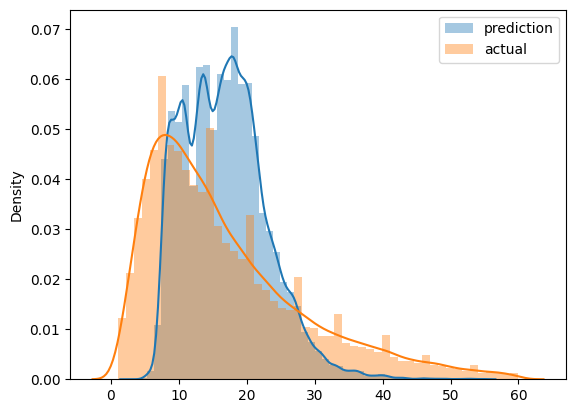

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [4]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [5]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [6]:
len(df_train), len(df_val)

(73908, 61921)

In [5]:
# df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
# df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [6]:
categorical = ['PULocationID', 'DOLocationID'] #'PULocationID', 'DOLocationID'
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [7]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


10.499110712717727

In [30]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [12]:
with mlflow.start_run():
    mlflow.set_tag("developer", "chen")

    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_mlflow")
    mlflow.sklearn.log_model(lr, artifact_path="models_mlflow")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setup

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:10.62311                          
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:13:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.45338                           
[2]	validation-rmse:8.60157                           
[3]	validation-rmse:7.98176                           
[4]	validation-rmse:7.54180                           
[5]	validation-rmse:7.23264                           
[6]	validation-rmse:7.01108                           
[7]	validation-rmse:6.84904                           
[8]	validation-rmse:6.73673                           
[9]	validation-rmse:6.65013                           
[10]	validation-rmse:6.58557                          
[11]	validation-rmse:6.53764                          
[12]	validation-rmse:6.49608                          
[13]	validation-rmse:6.46715                          
[14]	validation-rmse:6.44386                          
[15]	validation-rmse:6.42355                          
[16]	validation-rmse:6.40568                          
[17]	validation-rmse:6.39340                          
[18]	validation-rmse:6.38100                          
[19]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:13:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.11427                                                  
[1]	validation-rmse:10.20588                                                  
[2]	validation-rmse:9.45771                                                   
[3]	validation-rmse:8.84119                                                   
[4]	validation-rmse:8.34214                                                   
[5]	validation-rmse:7.94075                                                   
[6]	validation-rmse:7.61512                                                   
[7]	validation-rmse:7.35497                                                   
[8]	validation-rmse:7.14668                                                   
[9]	validation-rmse:6.98002                                                   
[10]	validation-rmse:6.84948                                                  
[11]	validation-rmse:6.74473                                                  
[12]	validation-rmse:6.65816                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:14:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.10628                                                  
[1]	validation-rmse:10.19409                                                  
[2]	validation-rmse:9.44076                                                   
[3]	validation-rmse:8.82690                                                   
[4]	validation-rmse:8.33033                                                   
[5]	validation-rmse:7.93057                                                   
[6]	validation-rmse:7.60638                                                   
[7]	validation-rmse:7.35012                                                   
[8]	validation-rmse:7.14201                                                   
[9]	validation-rmse:6.97771                                                   
[10]	validation-rmse:6.84619                                                  
[11]	validation-rmse:6.74047                                                  
[12]	validation-rmse:6.65928                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:14:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.27784                                                  
[1]	validation-rmse:8.94190                                                   
[2]	validation-rmse:8.04008                                                   
[3]	validation-rmse:7.44157                                                   
[4]	validation-rmse:7.05322                                                   
[5]	validation-rmse:6.79655                                                   
[6]	validation-rmse:6.63646                                                   
[7]	validation-rmse:6.53132                                                   
[8]	validation-rmse:6.46144                                                   
[9]	validation-rmse:6.41622                                                   
[10]	validation-rmse:6.38533                                                  
[11]	validation-rmse:6.36214                                                  
[12]	validation-rmse:6.34547                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:14:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01346                                                   
[1]	validation-rmse:7.59789                                                   
[2]	validation-rmse:7.00164                                                   
[3]	validation-rmse:6.74025                                                   
[4]	validation-rmse:6.61578                                                   
[5]	validation-rmse:6.55104                                                   
[6]	validation-rmse:6.51031                                                   
[7]	validation-rmse:6.47584                                                   
[8]	validation-rmse:6.46419                                                   
[9]	validation-rmse:6.44095                                                   
[10]	validation-rmse:6.42607                                                  
[11]	validation-rmse:6.40071                                                  
[12]	validation-rmse:6.38939                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:14:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.97803                                                   
[1]	validation-rmse:8.57973                                                   
[2]	validation-rmse:7.73516                                                   
[3]	validation-rmse:7.24016                                                   
[4]	validation-rmse:6.96224                                                   
[5]	validation-rmse:6.81304                                                   
[6]	validation-rmse:6.73190                                                   
[7]	validation-rmse:6.69098                                                   
[8]	validation-rmse:6.66858                                                   
[9]	validation-rmse:6.66113                                                   
[10]	validation-rmse:6.65756                                                  
[11]	validation-rmse:6.65721                                                  
[12]	validation-rmse:6.65760                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:15:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57489                                                  
[1]	validation-rmse:11.00060                                                  
[2]	validation-rmse:10.48297                                                  
[3]	validation-rmse:10.01781                                                  
[4]	validation-rmse:9.60018                                                   
[5]	validation-rmse:9.22736                                                   
[6]	validation-rmse:8.89091                                                   
[7]	validation-rmse:8.59004                                                   
[8]	validation-rmse:8.32595                                                   
[9]	validation-rmse:8.09069                                                   
[10]	validation-rmse:7.88034                                                  
[11]	validation-rmse:7.69311                                                  
[12]	validation-rmse:7.52789                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:15:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.90048                                                  
[1]	validation-rmse:9.86224                                                   
[2]	validation-rmse:9.04923                                                   
[3]	validation-rmse:8.41726                                                   
[4]	validation-rmse:7.92772                                                   
[5]	validation-rmse:7.55710                                                   
[6]	validation-rmse:7.27845                                                   
[7]	validation-rmse:7.05963                                                   
[8]	validation-rmse:6.89572                                                   
[9]	validation-rmse:6.77031                                                   
[10]	validation-rmse:6.66958                                                  
[11]	validation-rmse:6.59277                                                  
[12]	validation-rmse:6.53059                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:9.26752                                                   
 16%|█▌        | 8/50 [02:11<12:39, 18.08s/trial, best loss: 6.18374908481879]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:15:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.76611                                                   
[2]	validation-rmse:7.04745                                                   
[3]	validation-rmse:6.70237                                                   
[4]	validation-rmse:6.52920                                                   
[5]	validation-rmse:6.43560                                                   
[6]	validation-rmse:6.38579                                                   
[7]	validation-rmse:6.35408                                                   
[8]	validation-rmse:6.32874                                                   
[9]	validation-rmse:6.30961                                                   
[10]	validation-rmse:6.29563                                                  
[11]	validation-rmse:6.28329                                                  
[12]	validation-rmse:6.27388                                                  
[13]	validation-rmse:6.26384                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:15:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.02548                                                  
[1]	validation-rmse:10.05794                                                  
[2]	validation-rmse:9.27731                                                   
[3]	validation-rmse:8.65414                                                   
[4]	validation-rmse:8.15768                                                   
[5]	validation-rmse:7.76612                                                   
[6]	validation-rmse:7.46042                                                   
[7]	validation-rmse:7.21938                                                   
[8]	validation-rmse:7.02919                                                   
[9]	validation-rmse:6.87794                                                   
[10]	validation-rmse:6.76034                                                  
[11]	validation-rmse:6.66729                                                  
[12]	validation-rmse:6.59287                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:16:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.50192                                                    
[1]	validation-rmse:6.63793                                                    
[2]	validation-rmse:6.47789                                                    
[3]	validation-rmse:6.43207                                                    
[4]	validation-rmse:6.42637                                                    
[5]	validation-rmse:6.42980                                                    
[6]	validation-rmse:6.43113                                                    
[7]	validation-rmse:6.43979                                                    
[8]	validation-rmse:6.44556                                                    
[9]	validation-rmse:6.44957                                                    
[10]	validation-rmse:6.46384                                                   
[11]	validation-rmse:6.47014                                                   
[12]	validation-rmse:6.48060            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:16:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.08744                                                    
[1]	validation-rmse:6.88075                                                    
[2]	validation-rmse:6.55157                                                    
[3]	validation-rmse:6.44024                                                    
[4]	validation-rmse:6.39356                                                    
[5]	validation-rmse:6.36964                                                    
[6]	validation-rmse:6.35647                                                    
[7]	validation-rmse:6.34945                                                    
[8]	validation-rmse:6.35087                                                    
[9]	validation-rmse:6.34436                                                    
[10]	validation-rmse:6.34203                                                   
[11]	validation-rmse:6.33868                                                   
[12]	validation-rmse:6.33240            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:16:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.06035                                                   
[1]	validation-rmse:10.12011                                                   
[2]	validation-rmse:9.35950                                                    
[3]	validation-rmse:8.74089                                                    
[4]	validation-rmse:8.24620                                                    
[5]	validation-rmse:7.85841                                                    
[6]	validation-rmse:7.54508                                                    
[7]	validation-rmse:7.30389                                                    
[8]	validation-rmse:7.11191                                                    
[9]	validation-rmse:6.96224                                                    
[10]	validation-rmse:6.84929                                                   
[11]	validation-rmse:6.76014                                                   
[12]	validation-rmse:6.69241            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:17:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.10258                                                   
[1]	validation-rmse:10.18377                                                   
[2]	validation-rmse:9.42564                                                    
[3]	validation-rmse:8.80631                                                    
[4]	validation-rmse:8.30495                                                    
[5]	validation-rmse:7.89774                                                    
[6]	validation-rmse:7.57401                                                    
[7]	validation-rmse:7.31342                                                    
[8]	validation-rmse:7.10746                                                    
[9]	validation-rmse:6.94439                                                    
[10]	validation-rmse:6.81360                                                   
[11]	validation-rmse:6.70962                                                   
[12]	validation-rmse:6.62611            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:17:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35949                                                   
[1]	validation-rmse:10.62217                                                   
[2]	validation-rmse:9.98577                                                    
[3]	validation-rmse:9.43587                                                    
[4]	validation-rmse:8.96590                                                    
[5]	validation-rmse:8.56421                                                    
[6]	validation-rmse:8.22075                                                    
[7]	validation-rmse:7.93068                                                    
[8]	validation-rmse:7.68188                                                    
[9]	validation-rmse:7.47680                                                    
[10]	validation-rmse:7.30032                                                   
[11]	validation-rmse:7.15237                                                   
[12]	validation-rmse:7.02684            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:17:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.25519                                                    
[1]	validation-rmse:6.67798                                                    
[2]	validation-rmse:6.56885                                                    
[3]	validation-rmse:6.53211                                                    
[4]	validation-rmse:6.49911                                                    
[5]	validation-rmse:6.46441                                                    
[6]	validation-rmse:6.44963                                                    
[7]	validation-rmse:6.43172                                                    
[8]	validation-rmse:6.41531                                                    
[9]	validation-rmse:6.40829                                                    
[10]	validation-rmse:6.39910                                                   
[11]	validation-rmse:6.38600                                                   
[12]	validation-rmse:6.36822            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:17:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.50515                                                    
[1]	validation-rmse:8.03614                                                    
[2]	validation-rmse:7.29133                                                    
[3]	validation-rmse:6.92706                                                    
[4]	validation-rmse:6.75504                                                    
[5]	validation-rmse:6.67869                                                    
[6]	validation-rmse:6.64660                                                    
[7]	validation-rmse:6.63208                                                    
[8]	validation-rmse:6.62679                                                    
[9]	validation-rmse:6.62657                                                    
[10]	validation-rmse:6.63181                                                   
[11]	validation-rmse:6.64049                                                   
[12]	validation-rmse:6.64457            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:18:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01332                                                    
[1]	validation-rmse:7.53052                                                    
[2]	validation-rmse:6.88731                                                    
[3]	validation-rmse:6.58696                                                    
[4]	validation-rmse:6.44604                                                    
[5]	validation-rmse:6.35846                                                    
[6]	validation-rmse:6.31061                                                    
[7]	validation-rmse:6.28297                                                    
[8]	validation-rmse:6.26260                                                    
[9]	validation-rmse:6.24639                                                    
[10]	validation-rmse:6.23753                                                   
[11]	validation-rmse:6.23527                                                   
[12]	validation-rmse:6.23088            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:18:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.47567                                                    
[1]	validation-rmse:6.59429                                                    
[2]	validation-rmse:6.44603                                                    
[3]	validation-rmse:6.41099                                                    
[4]	validation-rmse:6.40776                                                    
[5]	validation-rmse:6.40846                                                    
[6]	validation-rmse:6.41439                                                    
[7]	validation-rmse:6.41908                                                    
[8]	validation-rmse:6.42373                                                    
[9]	validation-rmse:6.42816                                                    
[10]	validation-rmse:6.44311                                                   
[11]	validation-rmse:6.46105                                                   
[12]	validation-rmse:6.46523            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:18:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.18737                                                    
[1]	validation-rmse:7.68628                                                    
[2]	validation-rmse:6.98170                                                    
[3]	validation-rmse:6.65863                                                    
[4]	validation-rmse:6.49795                                                    
[5]	validation-rmse:6.41867                                                    
[6]	validation-rmse:6.36610                                                    
[7]	validation-rmse:6.33360                                                    
[8]	validation-rmse:6.31235                                                    
[9]	validation-rmse:6.30376                                                    
[10]	validation-rmse:6.29520                                                   
[11]	validation-rmse:6.28529                                                   
[12]	validation-rmse:6.28256            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.62251                                                   
 40%|████      | 20/50 [04:48<05:33, 11.13s/trial, best loss: 6.18374908481879]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:18:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.42858                                                    
[2]	validation-rmse:8.55204                                                    
[3]	validation-rmse:7.91597                                                    
[4]	validation-rmse:7.45635                                                    
[5]	validation-rmse:7.12900                                                    
[6]	validation-rmse:6.89724                                                    
[7]	validation-rmse:6.72848                                                    
[8]	validation-rmse:6.60750                                                    
[9]	validation-rmse:6.52240                                                    
[10]	validation-rmse:6.45699                                                   
[11]	validation-rmse:6.40962                                                   
[12]	validation-rmse:6.37099                                                   
[13]	validation-rmse:6.34045            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:18:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79690                                                   
[1]	validation-rmse:11.40940                                                   
[2]	validation-rmse:11.04914                                                   
[3]	validation-rmse:10.71340                                                   
[4]	validation-rmse:10.40121                                                   
[5]	validation-rmse:10.11119                                                   
[6]	validation-rmse:9.84266                                                    
[7]	validation-rmse:9.59401                                                    
[8]	validation-rmse:9.36360                                                    
[9]	validation-rmse:9.15092                                                    
[10]	validation-rmse:8.95421                                                   
[11]	validation-rmse:8.77348                                                   
[12]	validation-rmse:8.60603            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.63104                                                   
 44%|████▍     | 22/50 [05:19<06:31, 14.00s/trial, best loss: 6.18374908481879]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:19:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.10057                                                   
[2]	validation-rmse:10.61893                                                   
[3]	validation-rmse:10.18042                                                   
[4]	validation-rmse:9.78270                                                    
[5]	validation-rmse:9.42385                                                    
[6]	validation-rmse:9.09832                                                    
[7]	validation-rmse:8.80441                                                    
[8]	validation-rmse:8.54004                                                    
[9]	validation-rmse:8.30318                                                    
[10]	validation-rmse:8.08969                                                   
[11]	validation-rmse:7.90013                                                   
[12]	validation-rmse:7.72962                                                   
[13]	validation-rmse:7.57745            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.43182                                                   
[1]	validation-rmse:10.74868                                                   
[2]	validation-rmse:10.15487                                                   
 46%|████▌     | 23/50 [05:45<07:48, 17.33s/trial, best loss: 6.18374908481879]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:19:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.63506                                                    
[4]	validation-rmse:9.18583                                                    
[5]	validation-rmse:8.79731                                                    
[6]	validation-rmse:8.46257                                                    
[7]	validation-rmse:8.17655                                                    
[8]	validation-rmse:7.92928                                                    
[9]	validation-rmse:7.71717                                                    
[10]	validation-rmse:7.53391                                                   
[11]	validation-rmse:7.38010                                                   
[12]	validation-rmse:7.24629                                                   
[13]	validation-rmse:7.13312                                                   
[14]	validation-rmse:7.03529                                                   
[15]	validation-rmse:6.95251            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:19:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44970                                                    
[1]	validation-rmse:10.77964                                                    
[2]	validation-rmse:10.19248                                                    
[3]	validation-rmse:9.67940                                                     
[4]	validation-rmse:9.23245                                                     
[5]	validation-rmse:8.84612                                                     
[6]	validation-rmse:8.51151                                                     
[7]	validation-rmse:8.22068                                                     
[8]	validation-rmse:7.96998                                                     
[9]	validation-rmse:7.75386                                                     
[10]	validation-rmse:7.56727                                                    
[11]	validation-rmse:7.40923                                                    
[12]	validation-rmse:7.27139

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.79024                                                    
[1]	validation-rmse:11.39700                                                    
[2]	validation-rmse:11.03168                                                    
[3]	validation-rmse:10.69229                                                    
[4]	validation-rmse:10.37749                                                    
[5]	validation-rmse:10.08558                                                    
[6]	validation-rmse:9.81607                                                     
[7]	validation-rmse:9.56693                                                     
[8]	validation-rmse:9.33669                                                     
[9]	validation-rmse:9.12500                                                     
[10]	validation-rmse:8.92905                                                    
[11]	validation-rmse:8.74947                                                    
[12]	validation-rmse:8.58329

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:19:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:8.29040                                                    
[15]	validation-rmse:8.16118                                                    
[16]	validation-rmse:8.04296                                                    
[17]	validation-rmse:7.93415                                                    
[18]	validation-rmse:7.83464                                                    
[19]	validation-rmse:7.74314                                                    
[20]	validation-rmse:7.65933                                                    
[21]	validation-rmse:7.58248                                                    
[22]	validation-rmse:7.51261                                                    
[23]	validation-rmse:7.44761                                                    
[24]	validation-rmse:7.38747                                                    
[25]	validation-rmse:7.33343                                                    
[26]	validation-rmse:7.28378

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.58813                                                    


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:20:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.38874
[2]	validation-rmse:8.52473                                                     
[3]	validation-rmse:7.90374                                                     
[4]	validation-rmse:7.46489                                                     
[5]	validation-rmse:7.15390                                                     
[6]	validation-rmse:6.93284                                                     
[7]	validation-rmse:6.77632                                                     
[8]	validation-rmse:6.66040                                                     
[9]	validation-rmse:6.57729                                                     
[10]	validation-rmse:6.51704                                                    
[11]	validation-rmse:6.47085                                                    
[12]	validation-rmse:6.43399                                                    
[13]	validation-rmse:6.40716                                                    


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.38979                                                    
[1]	validation-rmse:10.67496                                                    
[2]	validation-rmse:10.05882                                                    
 54%|█████▍    | 27/50 [06:42<05:29, 14.31s/trial, best loss: 6.183654732186462]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:20:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.52420                                                     
[4]	validation-rmse:9.06926                                                     
[5]	validation-rmse:8.67694                                                     
[6]	validation-rmse:8.34262                                                     
[7]	validation-rmse:8.05994                                                     
[8]	validation-rmse:7.81844                                                     
[9]	validation-rmse:7.61138                                                     
[10]	validation-rmse:7.43708                                                    
[11]	validation-rmse:7.28672                                                    
[12]	validation-rmse:7.15993                                                    
[13]	validation-rmse:7.05215                                                    
[14]	validation-rmse:6.96121                                                    
[15]	validation-rmse:6.88400

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.69489                                                     
[1]	validation-rmse:11.22125                                                     
[2]	validation-rmse:10.78872                                                     
[3]	validation-rmse:10.39391                                                     
[4]	validation-rmse:10.03512                                                     
[5]	validation-rmse:9.70963                                                      
[6]	validation-rmse:9.41487                                                      
[7]	validation-rmse:9.14715                                                      
[8]	validation-rmse:8.90568                                                      
[9]	validation-rmse:8.68761                                                      
[10]	validation-rmse:8.48999                                                     
[11]	validation-rmse:8.31300                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:20:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[13]	validation-rmse:8.00869                                                     
[14]	validation-rmse:7.87925                                                     
[15]	validation-rmse:7.76313                                                     
[16]	validation-rmse:7.65833                                                     
[17]	validation-rmse:7.56457                                                     
[18]	validation-rmse:7.48000                                                     
[19]	validation-rmse:7.40444                                                     
[20]	validation-rmse:7.33697                                                     
[21]	validation-rmse:7.27636                                                     
[22]	validation-rmse:7.22059                                                     
[23]	validation-rmse:7.17157                                                     
[24]	validation-rmse:7.12710                                                     
[25]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.42236                                                     
[1]	validation-rmse:10.73175                                                     
 58%|█████▊    | 29/50 [07:13<05:18, 15.15s/trial, best loss: 6.1613599264734376]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:20:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.13244                                                     
[3]	validation-rmse:9.60822                                                      
[4]	validation-rmse:9.15979                                                      
[5]	validation-rmse:8.76780                                                      
[6]	validation-rmse:8.43491                                                      
[7]	validation-rmse:8.14705                                                      
[8]	validation-rmse:7.89882                                                      
[9]	validation-rmse:7.68976                                                      
[10]	validation-rmse:7.50931                                                     
[11]	validation-rmse:7.35415                                                     
[12]	validation-rmse:7.22307                                                     
[13]	validation-rmse:7.10910                                                     
[14]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:21:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50064                                                     
[1]	validation-rmse:10.87108                                                     
[2]	validation-rmse:10.31553                                                     
[3]	validation-rmse:9.82647                                                      
[4]	validation-rmse:9.39868                                                      
[5]	validation-rmse:9.02477                                                      
[6]	validation-rmse:8.69880                                                      
[7]	validation-rmse:8.41490                                                      
[8]	validation-rmse:8.16767                                                      
[9]	validation-rmse:7.95261                                                      
[10]	validation-rmse:7.76601                                                     
[11]	validation-rmse:7.60530                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:21:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.56193                                                    
[1]	validation-rmse:10.97969                                                    
[2]	validation-rmse:10.46094                                                    
[3]	validation-rmse:9.99840                                                     
[4]	validation-rmse:9.58754                                                     
[5]	validation-rmse:9.22492                                                     
[6]	validation-rmse:8.90337                                                     
[7]	validation-rmse:8.61828                                                     
[8]	validation-rmse:8.36972                                                     
[9]	validation-rmse:8.14909                                                     
[10]	validation-rmse:7.95704                                                    
[11]	validation-rmse:7.78682                                                    
[12]	validation-rmse:7.63930

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:21:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68955                                                    
[1]	validation-rmse:11.20993                                                    
[2]	validation-rmse:10.76885                                                    
[3]	validation-rmse:10.36549                                                    
[4]	validation-rmse:9.99601                                                     
[5]	validation-rmse:9.65756                                                     
[6]	validation-rmse:9.34821                                                     
[7]	validation-rmse:9.06679                                                     
[8]	validation-rmse:8.80954                                                     
[9]	validation-rmse:8.57322                                                     
[10]	validation-rmse:8.36226                                                    
[11]	validation-rmse:8.16849                                                    
[12]	validation-rmse:7.99447

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:22:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.84102                                                    
[1]	validation-rmse:9.76623                                                     
[2]	validation-rmse:8.93224                                                     
[3]	validation-rmse:8.29016                                                     
[4]	validation-rmse:7.80636                                                     
[5]	validation-rmse:7.43618                                                     
[6]	validation-rmse:7.16088                                                     
[7]	validation-rmse:6.95578                                                     
[8]	validation-rmse:6.80154                                                     
[9]	validation-rmse:6.68344                                                     
[10]	validation-rmse:6.59571                                                    
[11]	validation-rmse:6.52925                                                    
[12]	validation-rmse:6.47730

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.30711                                                    
 68%|██████▊   | 34/50 [09:16<06:31, 24.50s/trial, best loss: 6.151513120931956]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:22:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.52944                                                    
[2]	validation-rmse:9.86566                                                     
[3]	validation-rmse:9.30342                                                     
[4]	validation-rmse:8.82766                                                     
[5]	validation-rmse:8.42898                                                     
[6]	validation-rmse:8.09053                                                     
[7]	validation-rmse:7.80941                                                     
[8]	validation-rmse:7.57422                                                     
[9]	validation-rmse:7.37704                                                     
[10]	validation-rmse:7.21180                                                    
[11]	validation-rmse:7.07746                                                    
[12]	validation-rmse:6.96260                                                    
[13]	validation-rmse:6.86600

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:23:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.01793                                                    
[1]	validation-rmse:8.60809                                                     
[2]	validation-rmse:7.72366                                                     
[3]	validation-rmse:7.18574                                                     
[4]	validation-rmse:6.86093                                                     
[5]	validation-rmse:6.67353                                                     
[6]	validation-rmse:6.55423                                                     
[7]	validation-rmse:6.49346                                                     
[8]	validation-rmse:6.45484                                                     
[9]	validation-rmse:6.43407                                                     
[10]	validation-rmse:6.42403                                                    
[11]	validation-rmse:6.41769                                                    
[12]	validation-rmse:6.41287

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:23:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.51827                                                    
[1]	validation-rmse:10.89792                                                    
[2]	validation-rmse:10.34645                                                    
[3]	validation-rmse:9.85658                                                     
[4]	validation-rmse:9.42147                                                     
[5]	validation-rmse:9.03625                                                     
[6]	validation-rmse:8.69809                                                     
[7]	validation-rmse:8.39682                                                     
[8]	validation-rmse:8.13217                                                     
[9]	validation-rmse:7.90213                                                     
[10]	validation-rmse:7.70040                                                    
[11]	validation-rmse:7.52152                                                    
[12]	validation-rmse:7.36546

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:23:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79125                                                    
[1]	validation-rmse:11.39752                                                    
[2]	validation-rmse:11.02936                                                    
[3]	validation-rmse:10.68686                                                    
[4]	validation-rmse:10.36620                                                    
[5]	validation-rmse:10.06823                                                    
[6]	validation-rmse:9.79061                                                     
[7]	validation-rmse:9.53304                                                     
[8]	validation-rmse:9.29120                                                     
[9]	validation-rmse:9.06679                                                     
[10]	validation-rmse:8.85996                                                    
[11]	validation-rmse:8.66647                                                    
[12]	validation-rmse:8.48765

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.21429                                                    
 76%|███████▌  | 38/50 [11:15<06:51, 34.25s/trial, best loss: 6.151513120931956]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:24:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.37399                                                    
[2]	validation-rmse:9.66663                                                     
[3]	validation-rmse:9.07741                                                     
[4]	validation-rmse:8.58945                                                     
[5]	validation-rmse:8.18630                                                     
[6]	validation-rmse:7.85362                                                     
[7]	validation-rmse:7.58126                                                     
[8]	validation-rmse:7.35999                                                     
[9]	validation-rmse:7.17649                                                     
[10]	validation-rmse:7.02843                                                    
[11]	validation-rmse:6.90746                                                    
[12]	validation-rmse:6.80501                                                    
[13]	validation-rmse:6.72112

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:6.76399                                                     
[1]	validation-rmse:6.66268                                                     
[2]	validation-rmse:6.60019                                                     
 78%|███████▊  | 39/50 [11:27<05:04, 27.71s/trial, best loss: 6.151513120931956]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:25:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.56078                                                     
[4]	validation-rmse:6.54201                                                     
[5]	validation-rmse:6.51826                                                     
[6]	validation-rmse:6.50779                                                     
[7]	validation-rmse:6.49561                                                     
[8]	validation-rmse:6.47288                                                     
[9]	validation-rmse:6.46009                                                     
[10]	validation-rmse:6.45180                                                    
[11]	validation-rmse:6.44964                                                    
[12]	validation-rmse:6.44740                                                    
[13]	validation-rmse:6.43399                                                    
[14]	validation-rmse:6.42577                                                    
[15]	validation-rmse:6.42490

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:25:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.91825                                                    
[1]	validation-rmse:9.89092                                                     
[2]	validation-rmse:9.07524                                                     
[3]	validation-rmse:8.44560                                                     
[4]	validation-rmse:7.95745                                                     
[5]	validation-rmse:7.57764                                                     
[6]	validation-rmse:7.28985                                                     
[7]	validation-rmse:7.07027                                                     
[8]	validation-rmse:6.90292                                                     
[9]	validation-rmse:6.77580                                                     
[10]	validation-rmse:6.67999                                                    
[11]	validation-rmse:6.60413                                                    
[12]	validation-rmse:6.54854

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.22548                                                    
 82%|████████▏ | 41/50 [11:45<02:48, 18.76s/trial, best loss: 6.151513120931956]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:25:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.87377                                                     
[2]	validation-rmse:7.97064                                                     
[3]	validation-rmse:7.38728                                                     
[4]	validation-rmse:7.01300                                                     
[5]	validation-rmse:6.77040                                                     
[6]	validation-rmse:6.61162                                                     
[7]	validation-rmse:6.50527                                                     
[8]	validation-rmse:6.43288                                                     
[9]	validation-rmse:6.38819                                                     
[10]	validation-rmse:6.35630                                                    
[11]	validation-rmse:6.33108                                                    
[12]	validation-rmse:6.31598                                                    
[13]	validation-rmse:6.30382

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:25:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74131                                                    
[1]	validation-rmse:11.30431                                                    
[2]	validation-rmse:10.89958                                                    
[3]	validation-rmse:10.52588                                                    
[4]	validation-rmse:10.18009                                                    
[5]	validation-rmse:9.86115                                                     
[6]	validation-rmse:9.56700                                                     
[7]	validation-rmse:9.29676                                                     
[8]	validation-rmse:9.04901                                                     
[9]	validation-rmse:8.82160                                                     
[10]	validation-rmse:8.61295                                                    
[11]	validation-rmse:8.41938                                                    
[12]	validation-rmse:8.24341

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.79669                                                    
 86%|████████▌ | 43/50 [12:18<02:08, 18.41s/trial, best loss: 6.151513120931956]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:26:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.69884                                                     
[2]	validation-rmse:8.85823                                                     
[3]	validation-rmse:8.22087                                                     
[4]	validation-rmse:7.74442                                                     
[5]	validation-rmse:7.39059                                                     
[6]	validation-rmse:7.12593                                                     
[7]	validation-rmse:6.92698                                                     
[8]	validation-rmse:6.78107                                                     
[9]	validation-rmse:6.67318                                                     
[10]	validation-rmse:6.58795                                                    
[11]	validation-rmse:6.52509                                                    
[12]	validation-rmse:6.47643                                                    
[13]	validation-rmse:6.43575

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:26:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22901                                                    
[1]	validation-rmse:10.40130                                                    
[2]	validation-rmse:9.69964                                                     
[3]	validation-rmse:9.11469                                                     
[4]	validation-rmse:8.62832                                                     
[5]	validation-rmse:8.22689                                                     
[6]	validation-rmse:7.89207                                                     
[7]	validation-rmse:7.61712                                                     
[8]	validation-rmse:7.39353                                                     
[9]	validation-rmse:7.20723                                                     
[10]	validation-rmse:7.06180                                                    
[11]	validation-rmse:6.94183                                                    
[12]	validation-rmse:6.84505

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:26:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59293                                                    
[1]	validation-rmse:11.03249                                                    
[2]	validation-rmse:10.52794                                                    
[3]	validation-rmse:10.07259                                                    
[4]	validation-rmse:9.66255                                                     
[5]	validation-rmse:9.29440                                                     
[6]	validation-rmse:8.96503                                                     
[7]	validation-rmse:8.66867                                                     
[8]	validation-rmse:8.40309                                                     
[9]	validation-rmse:8.16538                                                     
[10]	validation-rmse:7.95500                                                    
[11]	validation-rmse:7.76741                                                    
[12]	validation-rmse:7.60162

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:27:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.48301                                                    
[1]	validation-rmse:10.83629                                                    
[2]	validation-rmse:10.26446                                                    
[3]	validation-rmse:9.76063                                                     
[4]	validation-rmse:9.31752                                                     
[5]	validation-rmse:8.92625                                                     
[6]	validation-rmse:8.58441                                                     
[7]	validation-rmse:8.28507                                                     
[8]	validation-rmse:8.02597                                                     
[9]	validation-rmse:7.79740                                                     
[10]	validation-rmse:7.60019                                                    
[11]	validation-rmse:7.42704                                                    
[12]	validation-rmse:7.27741

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:27:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.98419                                                    
[1]	validation-rmse:10.00342                                                    
[2]	validation-rmse:9.22379                                                     
[3]	validation-rmse:8.60750                                                     
[4]	validation-rmse:8.13197                                                     
[5]	validation-rmse:7.77247                                                     
[6]	validation-rmse:7.49442                                                     
[7]	validation-rmse:7.28154                                                     
[8]	validation-rmse:7.12103                                                     
[9]	validation-rmse:7.00099                                                     
[10]	validation-rmse:6.91296                                                    
[11]	validation-rmse:6.84660                                                    
[12]	validation-rmse:6.80111

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:28:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.56009                                                     
[1]	validation-rmse:8.07030                                                     
[2]	validation-rmse:7.28280                                                     
[3]	validation-rmse:6.87644                                                     
[4]	validation-rmse:6.66042                                                     
[5]	validation-rmse:6.54366                                                     
[6]	validation-rmse:6.47851                                                     
[7]	validation-rmse:6.43680                                                     
[8]	validation-rmse:6.41046                                                     
[9]	validation-rmse:6.39500                                                     
[10]	validation-rmse:6.38305                                                    
[11]	validation-rmse:6.37243                                                    
[12]	validation-rmse:6.36609

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.20239                                                    
[1]	validation-rmse:10.35966                                                    
[2]	validation-rmse:9.66146                                                     
[3]	validation-rmse:9.08519                                                     
[4]	validation-rmse:8.61199                                                     
[5]	validation-rmse:8.22669                                                     
 98%|█████████▊| 49/50 [15:03<00:26, 26.16s/trial, best loss: 6.151513120931956]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:28:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:7.90735                                                     
[7]	validation-rmse:7.65144                                                     
[8]	validation-rmse:7.44457                                                     
[9]	validation-rmse:7.27651                                                     
[10]	validation-rmse:7.14043                                                    
[11]	validation-rmse:7.02666                                                    
[12]	validation-rmse:6.93384                                                    
[13]	validation-rmse:6.86057                                                    
[14]	validation-rmse:6.79883                                                    
[15]	validation-rmse:6.74843                                                    
[16]	validation-rmse:6.70663                                                    
[17]	validation-rmse:6.67228                                                    
[18]	validation-rmse:6.64020

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

